# Quick demo: Reference-free 3D omics simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simspace as ss

In [2]:
shape = (100, 100, 40)
num_iteration = 5
custom_neighbor = ss.spatial.generate_offsets3D(4, 'manhattan')

## Generate random parameters for 3D simulation
parameters = ss.util.generate_random_parameters(n_group=3, n_state=8, seed=42)

In [3]:
## Convert parameters to the format required by SimSpace
n_state = parameters['n_state']
n_group = parameters['n_group']

niche_theta = np.zeros((n_group, n_group))
niche_theta[np.triu_indices(n_group, 1)] = parameters['niche_theta']
niche_theta = niche_theta + niche_theta.T - np.diag(niche_theta.diagonal())
np.fill_diagonal(niche_theta, 1)

theta_list = []
for i in range(n_group):
    theta_tmp = np.zeros((n_state, n_state))
    theta_tmp[np.triu_indices(n_state, 1)] = parameters['theta_list'][i]
    theta_tmp = theta_tmp + theta_tmp.T - np.diag(theta_tmp.diagonal())
    np.fill_diagonal(theta_tmp, 1)
    theta_list.append(theta_tmp)

density_replicates = np.array(parameters['density_replicates'])
density_replicates[density_replicates < 0] = 0
phi_replicates = parameters['phi_replicates']

In [4]:
sim = ss.SimSpace(
    shape = shape,
    num_states = n_state,
    num_iterations= num_iteration,
    theta=theta_list,
    phi=phi_replicates,
    neighborhood=custom_neighbor, 
    random_seed=0)
sim.initialize3D()   # Initialize the grid
sim.create_niche3D(num_niches=n_group, n_iter=4, theta_niche=niche_theta)
sim.gibbs_sampler3D()    # Gibbs sampling
sim.density_sampler(density_replicates)  # Cell density of each niche
sim.perturbation3D(step = 0.2)     # Perturbation

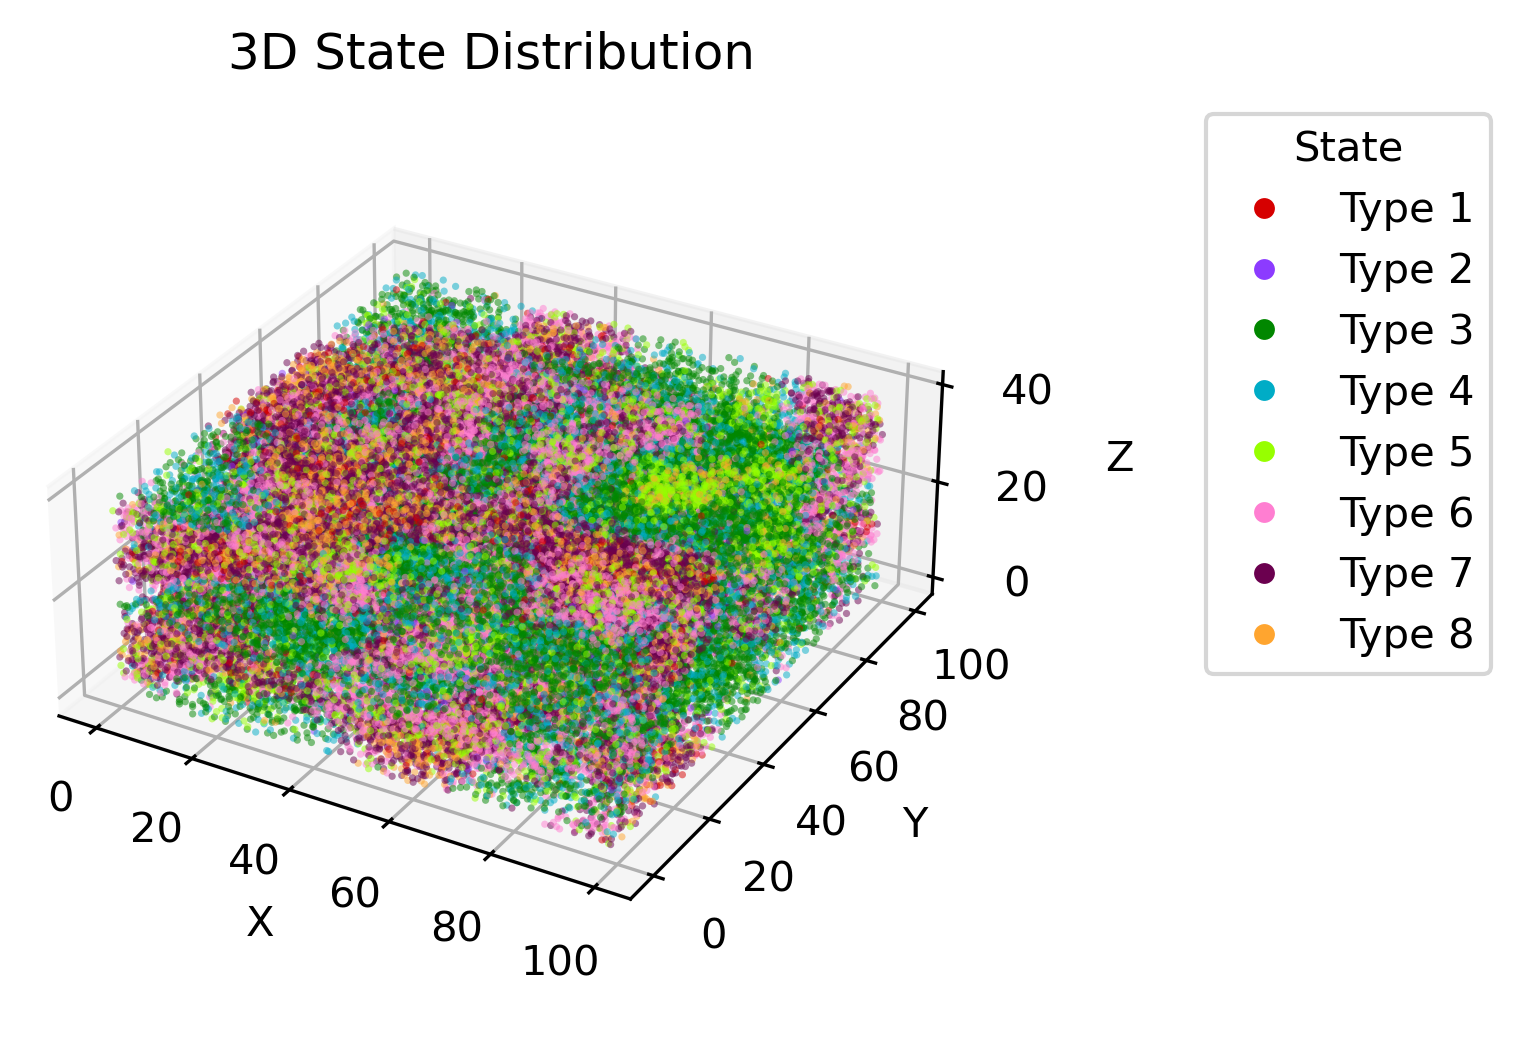

In [5]:
from matplotlib.lines import Line2D
import colorcet as cc

# Create a DataFrame for easier plotting
df = pd.DataFrame(sim.meta, columns=['x', 'y', 'z', 'state'])
cmap = sns.color_palette(cc.glasbey, n_colors=8)

# Plot the 3D scatter plot
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(111, projection='3d')
df['state'] = df['state'].astype('category')
scatter = ax.scatter(df['x'], df['y'], df['z'], c=df['state'].cat.codes, cmap=plt.cm.colors.ListedColormap(cmap), alpha=0.5, linewidths=0, s=3)
# Add legend for states
state_labels = [f'Type {cat + 1}' for cat in df['state'].cat.categories]
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=cmap[i], markersize=6)
                   for i, label in enumerate(state_labels)]
ax.legend(handles=legend_elements, title='State', bbox_to_anchor=(1.25, 1), loc='upper left')
ax.set_aspect('equal')
ax.set_zticks([0, 20, 40])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('3D State Distribution')

plt.show()

In [6]:
sim.create_omics(n_genes=100, bg_ratio=0, bg_param = (1, 0.5), marker_param = (5, 2), spatial=False)

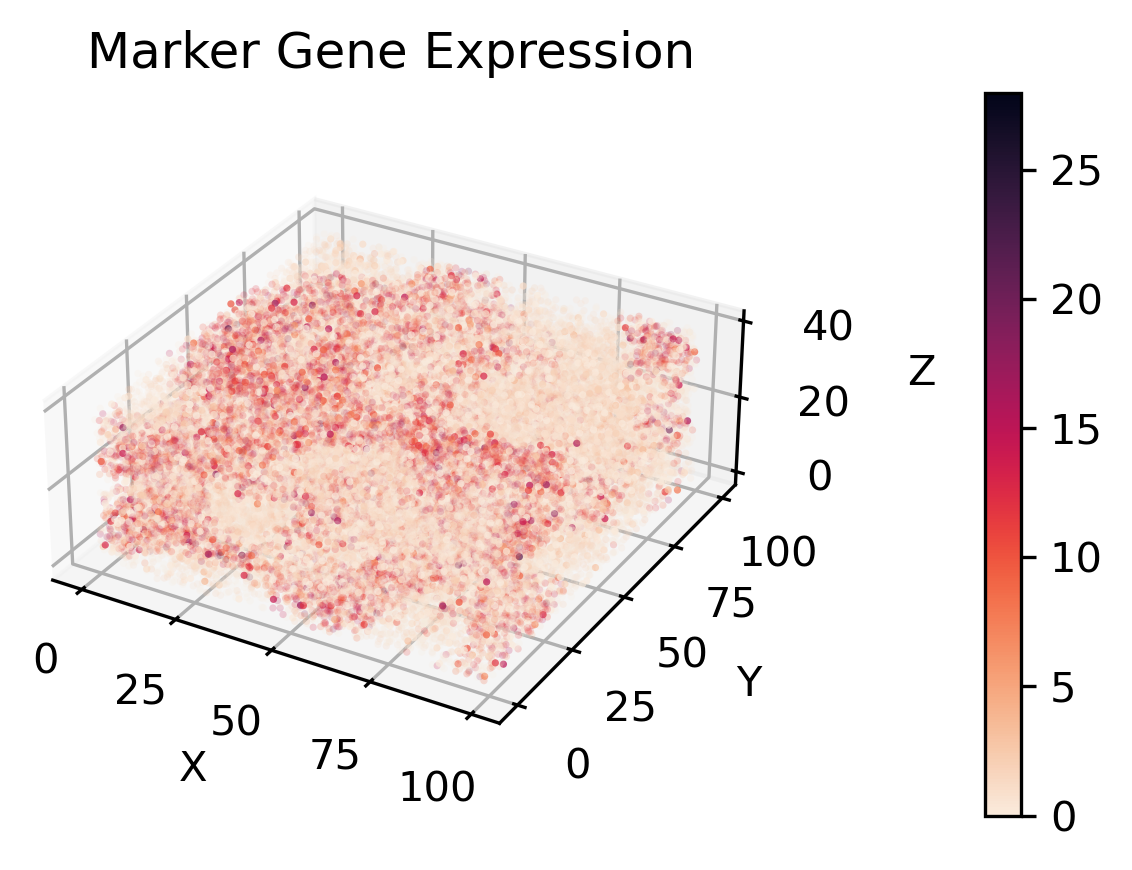

In [7]:
df = pd.DataFrame(sim.meta, columns=['x', 'y', 'z', 'state'])
df['gene'] = sim.omics['Gene_48']
cmap = sns.color_palette('rocket_r', as_cmap=True)
df['alpha'] = df['gene']/df['gene'].max()
df['alpha'][df['alpha'] < 0.4] = 0.2
df['alpha'][df['alpha'] > 0.4] = 0.7

# Plot the 3D scatter plot
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')
df['state'] = df['state'].astype('category')
scatter = ax.scatter(df['x'], df['y'], df['z'], c=df['gene'], alpha=df['alpha'], linewidths=0, s=3, cmap=cmap)
# Add legend
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.14)
# cbar.set_label(feature.name)
ax.set_aspect('equal')
ax.set_zticks([0, 20, 40])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Marker Gene Expression')
plt.tight_layout()
plt.show()

In [9]:
sim.meta.head()

,state,x,y,z
0,4,0.352810,-0.163289,5.252325
1,6,0.080031,-0.002245,6.799134
2,7,0.195748,0.098850,8.010895
3,6,0.448179,-0.341948,26.679266
4,5,0.373512,0.123146,32.960261


In [10]:
sim.omics.head()

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_90,Gene_91,Gene_92,Gene_93,Gene_94,Gene_95,Gene_96,Gene_97,Gene_98,Gene_99
0,15.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,...,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,2.0,16.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0
2,0.0,18.0,1.0,0.0,1.0,3.0,0.0,5.0,1.0,0.0,...,22.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,13.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0
4,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,2.0
